In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Produces masks from prompts using an ONNX model

SAM's prompt encoder and mask decoder are very lightweight, which allows for efficient computation of a mask given user input. This notebook shows an example of how to export and use this lightweight component of the model in ONNX format, allowing it to run on a variety of platforms that support an ONNX runtime.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/onnx_model_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. The latest stable versions of PyTorch and ONNX are recommended for this notebook. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Note that this notebook requires both the `onnx` and `onnxruntime` optional dependencies, in addition to `opencv-python` and `matplotlib` for visualization.

In [45]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [46]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## Export an ONNX model

Set the path below to a SAM model checkpoint, then load the model. This will be needed to both export the model and to calculate embeddings for the model.

In [47]:
checkpoint = "../assets/model/sam_vit_b_01ec64.pth"
model_type = "vit_b"

In [48]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)

The script `segment-anything/scripts/export_onnx_model.py` can be used to export the necessary portion of SAM. Alternatively, run the following code to export an ONNX model. If you have already exported a model, set the path below and skip to the next section. Assure that the exported ONNX model aligns with the checkpoint and model type set above. This notebook expects the model was exported with the parameter `return_single_mask=True`.

In [49]:
onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

In [51]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    

If desired, the model can additionally be quantized and optimized. We find this improves web runtime significantly for negligible change in qualitative performance. Run the next cell to quantize the model, or skip to the next section otherwise.

In [52]:
onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

## Example Image

In [53]:
image = cv2.imread('images/dogs.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

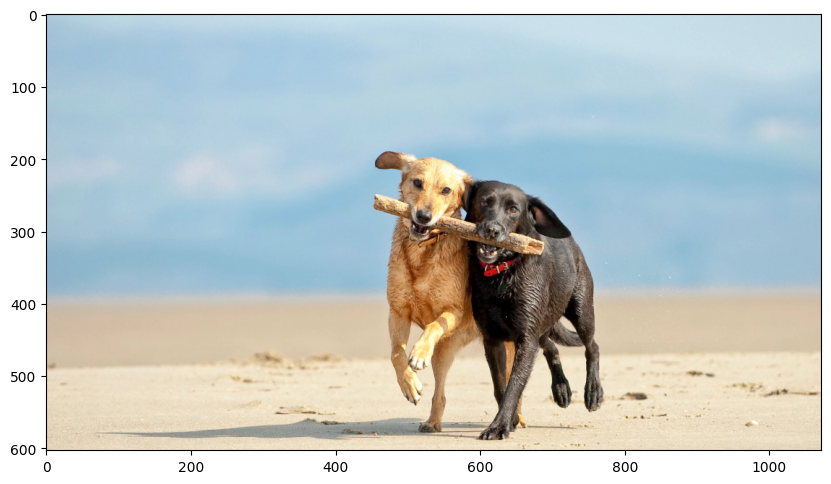

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Using an ONNX model

Here as an example, we use `onnxruntime` in python on CPU to execute the ONNX model. However, any platform that supports an ONNX runtime could be used in principle. Launch the runtime session below:

In [55]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

To use the ONNX model, the image must first be pre-processed using the SAM image encoder. This is a heavier weight process best performed on GPU. SamPredictor can be used as normal, then `.get_image_embedding()` will retreive the intermediate features.

In [56]:
sam.to()
predictor = SamPredictor(sam)

In [57]:
predictor.set_image(image)

In [58]:
image_embedding = predictor.get_image_embedding().cpu().numpy()
np.save("dogs_embedding.npy", image_embedding)

In [44]:
image_embedding.shape

(1, 256, 64, 64)

The ONNX model has a different input signature than `SamPredictor.predict`. The following inputs must all be supplied. Note the special cases for both point and mask inputs. All inputs are `np.float32`.
* `image_embeddings`: The image embedding from `predictor.get_image_embedding()`. Has a batch index of length 1.
* `point_coords`: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. *Coordinates must already be transformed to long-side 1024.* Has a batch index of length 1.
* `point_labels`: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. *If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.*
* `mask_input`: A mask input to the model with shape 1x1x256x256. This must be supplied even if there is no mask input. In this case, it can just be zeros.
* `has_mask_input`: An indicator for the mask input. 1 indicates a mask input, 0 indicates no mask input.
* `orig_im_size`: The size of the input image in (H,W) format, before any transformation. 

Additionally, the ONNX model does not threshold the output mask logits. To obtain a binary mask, threshold at `sam.mask_threshold` (equal to 0.0).

### Example point input

In [17]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

Add a batch index, concatenate a padding point, and transform.

In [18]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


Create an empty mask input and an indicator for no mask.

In [19]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

Package the inputs to run in the onnx model

In [20]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

Predict a mask and threshold it.

In [21]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [22]:
masks.shape

(1, 1, 603, 1072)

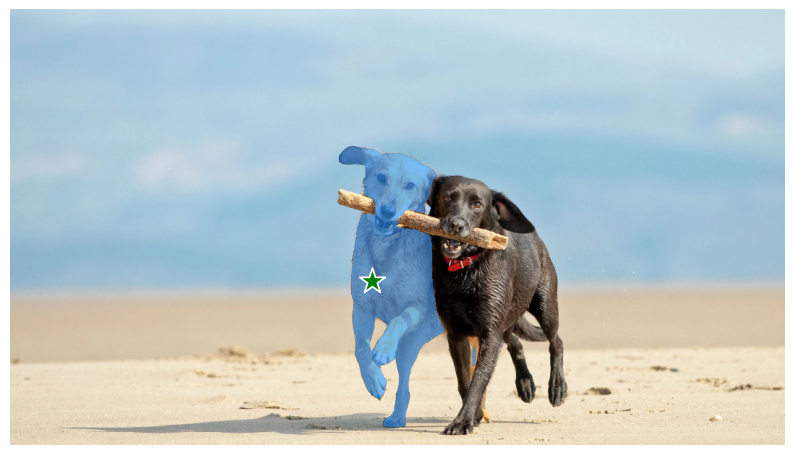

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Example mask input

In [24]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

Transform the points as in the previous example.

In [25]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

The `has_mask_input` indicator is now 1.

In [26]:
onnx_has_mask_input = np.ones(1, dtype=np.float32)

Package inputs, then predict and threshold the mask.

In [27]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

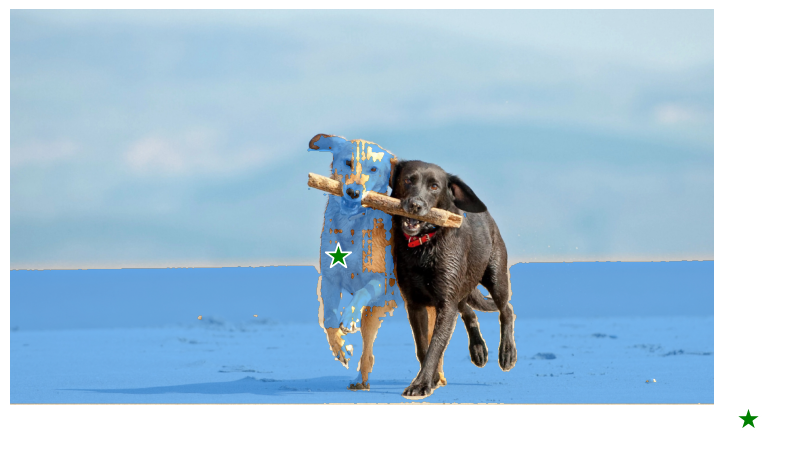

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Example box and point input

In [29]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

Add a batch index, concatenate a box and point inputs, add the appropriate labels for the box corners, and transform. There is no padding point since the input includes a box input.

In [30]:
onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

Package inputs, then predict and threshold the mask.

In [31]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()